Given certain amount of initial money, we will have three options; buy, sell and hold.

I will use DQN that comes from http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html

In [2]:
!sudo pip install yahoo_finance

Downloading/unpacking yahoo_finance
  Running setup.py (path:/tmp/pip_build_root/yahoo-finance/setup.py) egg_info for package yahoo-finance
    
  Running setup.py install for yahoo-finance
    
    Installing yahoo-finance script to /usr/local/bin
  Could not find .egg-info directory in install record for yahoo_finance
Cleaning up...


In [3]:
#generic
%matplotlib inline
from __future__ import print_function

import numpy as np
import time
# import quandl 
import matplotlib.pyplot as plt

from yahoo_finance import Share

Since GPU is not available now, I will use tensorflow for cpu

In [4]:
def get_data_by_key(key, data):
    data_it = iter(data)
    return_data = []
    flag = True
    for d in data_it:
        if key !="Date":
            return_data.append(float(d[key]))
        else:
            return_data.append(d[key])
        
    return np.array(return_data)

Let's have expereiments with Yahoo stock data

In [5]:
start_date="2014-04-01"
end_date="2016-04-01"
print ("getting data ...")
share = Share('GOOG')
hist_data = share.get_historical(start_date=start_date, end_date=end_date)
price = get_data_by_key('Open', hist_data)
date = get_data_by_key('Date', hist_data)

getting data ...


# convert date label format for plot

In [6]:
import datetime

def convert_time_format(date):
    date_tilde = date.split("-")
    date_tilde = map(int, date_tilde)
    return datetime.datetime(*date_tilde)

In [7]:
date_label=[]
for i in xrange(len(date)):
    date_label.append(convert_time_format(date[i]))

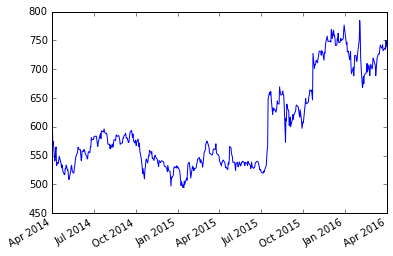

In [8]:
plt.plot(date_label, price)
plt.gcf().autofmt_xdate()

# DQN with MLP

I will try DQN with simple Multi Layer Perceptron

In [9]:
import tensorflow as tf

In [10]:
class DQNMLP(object):
    def __init__(self, n_stock, hidden_layers, n_actions, activation=tf.sigmoid,  gam=0.99, n_history=4, n_batch=32, freq_target_update=10, is_initialize=True):
        """initialized approximate value function
        
        Args:
            layers(list): list of the number of nodes in each layer
                last layer should be 3 because actions will be sell(-1), hold(0), buy(1)
            gam (float): discount factor
            n_history(int): nubmer of history that will be used as input
            n_batch (int): batch size
            freq_target_update (int): frequency of update for target network
            is_intialized(optional) (bool): if True, the graph will be initialized
        """
        print ("building model....")
        self.n_stock = n_stock
        self.hidden_layers = hidden_layers
        self.n_actions = n_actions
        self.activation = activation
        self.gam = gam
        self.n_history = n_history
        self.n_batch = n_batch
        slef.freq_target_update = freq_target_update
        
        # intialize graph to avoid conflications
        if is_initialize is True:
            sess  = tf.InteractiveSession()
            tf.reset_default_graph()
            sess.close()
            
        self._stock_data = tf.placeholder(tf.float32, [n_batch, n_history, n_stock], name= "stock_data")
        # the amount of cash player holds
        self._cash = tf.placeholder(tf.float32, [n_batch, n_history], name="cash")
        # the amount of stocks player holds
        self._hold_stock = tf.placeholder(tf.float32, [n_batch, n_history], name="hold_stock")
        
        # change format for training
        stock_data_tilde = tf.reshape(self._stock_data, [n_batch, n_history * n_stock])
        self._input = tf.concat(0, [stock_data_tilde, self._cash, self._hold_stock], name="input")
        self._target = tf.placeholder(tf.float32, [n_batch], name="target")
        
        # normalization for input
        n_layer0 = n_history * (n_stock + 1 + 1)
        shape = [n_layer0]
        gamma = tf.Variable(tf.constant(1.0, shape=shape), name="gamma")
        beta = tf.Variable(tf.constant(0.0, shape=shape), name="beta")
        self.normalized_input = self.batch_normalization(self._input, shape, gamma, beta)
                
        # keep parameters for pretraining
        self.gamma_list = []
        self.beta_list = []
        self.gamma_list.append(gamma)
        self.beta_list.append(beta)
        
        # parameters
        self.W_list = []
        self.b_list = []
        
        # the name of variable scope will be layer0, layer1, ...
        x = self.normalized_input
        n_in = n_layer0
        for i_layer in xrange(len(hidden_layers)):
            with tf.variable_scope("hidden_layer%d" % i_layer):
                n_out = hidden_layers[i_layer]
                W = self.weight_variable([n_in, n_out])
                b = self.bias_variable([n_out])
                n_in = n_out
                
                # keep parameters for pretraining
                self.W_list.append(W)
                self.b_list.append(b)
                
                z = tf.matmul(x, W) + b
      
                shape = [n_out]
                gamma = tf.Variable(tf.constant(1.0, shape=shape), name="gamma")
                beta = tf.Variable(tf.constant(0.0, shape=shape), name="beta")
                
                # keep parameters for pretraining
                self.gamma_list.append(gamma)
                self.beta_list.append(beta)
                
                normalized_z = self.batch_normalization(z, shape, gamma, beta)
                x = self.activation(normalized_z)
                
        # each node should be corresponding to each action
        n_out = n_actions
        W = self.weight_variable([n_in, n_out], name="weight_out")
        b = self.bias_variable([n_out], name="bias_out")
        n_in = n_out
                
        # keep parameters for pretraining
        self.W_list.append(W)
        self.b_list.append(b)
        self._output = tf.matmul(x, W) + b
        
        # choose action for evaluation
        self._action = tf.palceholder(tf.int32, [n_batch], name="action")
        
        
        
        # training graph
        self._learning_rate = tf.placeholder(tf.float32, shape=[], name="learning_rate")
        self.loss = tf.reduce_mean(tf.square(self._Q - self._target))
        # fixate on using this optimizer, otherwize, otherwise endup using unecessary graph nose
        self.optimizer = tf.train.AdamOptimizer(self._learning_rate, name="Optimizer")
        self.train = self.optimizer.minimize(self.loss)   
        
    def weight_variable(self, shape):
        initial = tf.truncated_normal(shape, stddev=1.0)
        return tf.Variable(initial, name="weight")
        
    def bias_variable(self, shape):
        initial = tf.constant(0.0, shape=shape)
        return tf.Variable(initial, name="bias")
        
    def batch_normalization(self, input, shape, gamma=None, beta=None):
        # input should be hidden_dim
        eps = 1e-5
        if gamma is None:
            gamma = tf.Variable(tf.constant(1.0, shape=shape))
        if beta is None:
            beta = tf.Variable(tf.constant(0.0, shape=shape))
        mean, variance = tf.nn.moments(input, [0])
        return gamma * (input - mean) / tf.sqrt(variance + eps) + beta
    
    def eps_greedy(self, eps, cash, stock, sess):
        """Return action chosen by greedy algorithm"""
        u = np.random.uniform()
        actions = [-1, 0, 1]
        if u < 1 - eps:
            q_list = []
            for a in actions:
                q = self._Q.eval(session=sess, 
                                    feed_dict={self._action: a, 
                                                      self._cash: cash,
                                                      self._stock: stock})
                q_list.append(q)
            action = actions[np.argmax(q_list)]
        else:
            action = actions[np.random.randint(0, 3)]
        
        return action
                
    
    def training(self, data, n_memory=20, eps=0.1, init_cash=10000, init_stock=0, gam=0.95, learning_rate=1e-4, n_epochs=100):
        """training DQN which consider three actions; sell, buy, hold
              money and n_stock are considered as state variable
        
        Args:
            data (list): stock price for one company
            n_memory (int): the number of data that is used for Experience Replay
            eps (float): the epsilon of greedy epsilon used for behavior policy
            init_cash (float): initial available cash
            init_stock (int): the number of stock data 
        """
        init_op = tf.initialize_all_variables()
        saver = tf.train.Saver()
        T = len(data)
        print_freq = int(n_epochs / 10)
        
        print ("training....")
        with tf.Session() as sess:
            sess.run(init_op)
            value_list  = []
            for epoch in xrange(n_epochs):
                lr = learning_rate
                cash = init_cash
                stock = init_stock
                # memory pool used for Experience Replay
                # length should be less than n_memory
                memory = []
                for t in xrange(T - 1):
                    # select action with e-greedy
                    # but:+1, hold: 0, sell -1
                    action = self.eps_greedy(eps, cash, stock, sess)
                    new_cash = cash - data[t] * action
                    new_stock = stock + action
                    # add memory pools whose capacity is up to n_memory
                    reward = new_stock * (data[t + 1] - data[t])
                    transition = [cash, stock, action, reward, new_cash, new_stock]
                    if len(memory) == n_memory:
                        del memory[0]
                    memory.append(transition)
                    cash = new_cash
                    stock = new_stock
                    
                    # select transition from pool
                    idx = np.random.randint(0, len(memory))
                    trans = memory[idx]
                    c = trans[0]
                    s = trans[1]
                    a = trans[2]
                    r = trans[3]
                    new_c = trans[4]
                    new_s = trans[5]
                    new_a = self.eps_greedy(eps, new_c, new_s, sess)
                    q = self._Q.eval(session=sess, 
                                        feed_dict={self._action: new_a, 
                                                          self._cash: new_c,
                                                          self._stock: new_s})
                    target = q + r
                    sess.run(self.train, 
                                    feed_dict={self._action: a, 
                                                      self._cash: c,
                                                      self._stock: s,
                                                      self._target: target,
                                                      self._learning_rate:lr})  
                    
                value = cash + data[-1] * stock
                value_list.append(value)
                if epoch % print_freq == 0:
                    print ("epoch: %d, final value:%f, stock:%d, cash:%f" % (epoch, value, stock, cash))
           
            save_path = saver.save(sess, "/jupyter/tomoaki/DQN/trained_params.ckpt")
            print("Model saved in file: %s" % save_path)
           
        return value_list

In [11]:
test_idx = date_label.index(datetime.datetime(2015, 4, 1, 0, 0))

train = price[:test_idx]
test = price[test_idx:]
date_test = date_label[test_idx:]


dqn = DQNMLP(layers=[3, 3, 1])
value = dqn.training(train, n_epochs=100, init_cash=10000)

building model....
training....
epoch: 0, final value:34681.048451, stock:-235, cash:161781.368796
epoch: 10, final value:33345.962297, stock:-221, cash:152874.348664
epoch: 20, final value:34297.155545, stock:-232, cash:159774.918609
epoch: 30, final value:33088.777039, stock:-221, cash:152617.163406
epoch: 40, final value:34283.564980, stock:-225, cash:155975.361055
epoch: 50, final value:33968.029888, stock:-221, cash:153496.416255
epoch: 60, final value:33104.534968, stock:-225, cash:154796.331043
epoch: 70, final value:33313.294785, stock:-224, cash:154464.238433
epoch: 80, final value:35022.635824, stock:-236, cash:162663.808596
epoch: 90, final value:32550.529672, stock:-220, cash:151538.063612


NotFoundError: /jupyter/tomoaki/DQN/trained_params.ckpt.tempstate3457440370430043291
	 [[Node: save/save = SaveSlices[T=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/save/tensor_names, save/save/shapes_and_slices, beta/_186197, beta/Optimizer/_186199, beta/Optimizer_1/_186201, beta1_power/_186203, beta2_power/_186205, beta_1/_186207, beta_1/Optimizer/_186209, beta_1/Optimizer_1/_186211, gamma/_186213, gamma/Optimizer/_186215, gamma/Optimizer_1/_186217, gamma_1/_186219, gamma_1/Optimizer/_186221, gamma_1/Optimizer_1/_186223, layer0/bias/_186225, layer0/bias/Optimizer/_186227, layer0/bias/Optimizer_1/_186229, layer0/weight/_186231, layer0/weight/Optimizer/_186233, layer0/weight/Optimizer_1/_186235, layer1/bias/_186237, layer1/bias/Optimizer/_186239, layer1/bias/Optimizer_1/_186241, layer1/weight/_186243, layer1/weight/Optimizer/_186245, layer1/weight/Optimizer_1/_186247)]]
Caused by op u'save/save', defined at:
  File "/home/tomoaki/anaconda2/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/tomoaki/anaconda2/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py", line 596, in launch_instance
    app.start()
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 442, in start
    ioloop.IOLoop.instance().start()
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py", line 883, in start
    handler_func(fd_obj, events)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py", line 391, in execute_request
    user_expressions, allow_stdin)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py", line 199, in do_execute
    shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-112385dd4e6b>", line 9, in <module>
    value = dqn.training(train, n_epochs=100, init_cash=10000)
  File "<ipython-input-10-ca58a6386be2>", line 133, in training
    saver = tf.train.Saver()
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 854, in __init__
    restore_sequentially=restore_sequentially)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 516, in build
    save_tensor = self._AddSaveOps(filename_tensor, vars_to_save)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 212, in _AddSaveOps
    save = self.save_op(filename_tensor, vars_to_save)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/training/saver.py", line 164, in save_op
    tensor_slices=[vs.slice_spec for vs in vars_to_save])
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/io_ops.py", line 179, in _save
    tensors, name=name)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/ops/gen_io_ops.py", line 438, in _save_slices
    data=data, name=name)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/op_def_library.py", line 710, in apply_op
    op_def=op_def)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 2298, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/tomoaki/anaconda2/lib/python2.7/site-packages/tensorflow/python/framework/ops.py", line 1232, in __init__
    self._traceback = _extract_stack()


# DRQN

In [70]:
type(3)

int

In [26]:
q > 0

True